In [1]:
import numpy as np
import sobol_seq
from scipy.stats import norm
from concurrent.futures import ProcessPoolExecutor
import time

### Постановка задачи: Стохастическое дифференциальное уравнение

Рассмотрим модель, которая описывает динамику цены актива $ S(t) $ с помощью стохастического дифференциального уравнения (СДУ):

$$
dS(t) = \mu S(t) \, dt + \sigma S(t) \, dW(t) \quad (*)
$$

где:
- $ S(t) $ — цена актива в момент времени $ t $,
- $ \mu $ — средний темп роста (ожидаемая доходность актива),
- $ \sigma $ — волатильность актива,
- $ dW(t) $ — приращение винеровского процесса $ W(t) $, которое моделирует случайные колебания цен актива.


### I. Логарифмическое преобразование и лемма Ито

Для упрощения решения уравнения применим логарифмическое преобразование. Пусть $ Y(t) = \ln(S(t)) $. 

**Лемма(Ито):** Пусть $ Y(t) = f(X(t), t) $

$$
dY(t) = \frac{\partial f}{\partial t} \, dt + \frac{\partial f}{\partial X} \, dX(t) + \frac{1}{2} \frac{\partial^2 f}{\partial X^2} \, (dX(t))^2 \quad (**)
$$



Используя правило Ито, мы найдем выражение для $ dX(t) $:


$$
dX(t) = d(\ln(S(t))) = \frac{1}{S(t)} dS(t) - \frac{1}{2} \frac{1}{S(t)^2} (dS(t))^2
$$

Подставим $ (*) $ в это выражение.


$$
dX(t) = \frac{1}{S(t)} (\mu S(t) \, dt + \sigma S(t) \, dW(t)) - \frac{1}{2} \frac{\sigma^2 S(t)^2}{S(t)^2} \, dt
$$

После упрощения:

$$
dX(t) = \left(\mu - \frac{\sigma^2}{2}\right) \, dt + \sigma \, dW(t)
$$

Теперь у нас есть уравнение для $ X(t) $ (логарифма цены актива) в следующем виде:

$$
dX(t) = \left(\mu - \frac{\sigma^2}{2}\right) dt + \sigma dW(t)
$$

### II. Решение уравнения для $ X(t) $

Это уравнение для $ X(t) $ можно проинтегрировать. Поскольку $ dX(t) $ — линейное уравнение, его решение имеет вид:

$$
X(t) = X(0) + \left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W(t)
$$

Так как $ X(0) = \ln(S_0) $, где $ S_0 $ — начальная цена актива, подставим это значение:

$$
X(t) = \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W(t)
$$


### III. Возвращение к исходному неизвестному

Теперь вернемся к цене актива $ S(t) $, используя обратное преобразование $ S(t) = e^{X(t)} $:

$$
S(t) = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W(t)\right)
$$

при этом используя свойства Винеровского процесса имеем:

$$
S(t) = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma \sqrt{T} Z \right)
$$

где:
- $ S_0 $ — начальная цена актива,
- $ \mu $ — средний темп роста,
- $ \sigma $ — волатильность,
- $ Z \sim N(0, 1) $.

Полученная формула описывает цену актива в модели геометрического броуновского движения.

In [25]:
# Параметры опциона и модели

S0 = 100        # начальная цена актива
T = 1           # конечное время 
mu = 0.05       # средний темп роста
sigma = 0.2     # волатильность
N = 100000      # количество моделируемых путей

K = 100         # цена страйка

In [26]:
# Функция для оценки цены опциона с использованием последовательности Соболя
def monte_carlo_option_price(path_n, seed, european=False):
    # Генерация квазислучайных чисел
    norm_randoms = sample_normal_distribution(path_n)

    # Расчет конечных цен актива
    S_T = S0 * np.exp((mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * norm_randoms)

    # Вычисление цены опциона по формуле дисконтированной средней прибыли
    if european:
        payoff = np.maximum(S_T - K, 0)
        option_price = np.exp(-mu * T) * np.mean(payoff)
    else:
        option_price = np.mean(S_T)

    return option_price

# Генерация квазислучайных чисел
def sample_normal_distribution(point_n, numpy=False):
    if not numpy:
        sobol_points = sobol_seq.i4_sobol_generate(1, point_n)
        norm_randoms = norm.ppf(sobol_points).flatten()  
    else:
        norm_randoms = np.random.normal(0, 1, point_n)

    return norm_randoms

# Распараллеливание процесса
def parallel_monte_carlo(N, num_workers):
    paths_per_worker = N // num_workers
    seeds = np.random.randint(1, 100000, size=num_workers)  # семена для разных потоков

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = executor.map(monte_carlo_option_price, [paths_per_worker] * num_workers, seeds)

    return np.mean(list(results))

In [27]:
import matplotlib.pyplot as plt

def plot_trajectories(trajectory_n, point_n):
    fig, axs = plt.subplots()

    t = np.linspace(0, 1, point_n)
    for _ in range(trajectory_n):
        norm_randoms = np.random.normal(0, 1, point_n)

        option_prices = S0 * np.exp((mu - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * norm_randoms)

        axs.plot(t, option_prices)

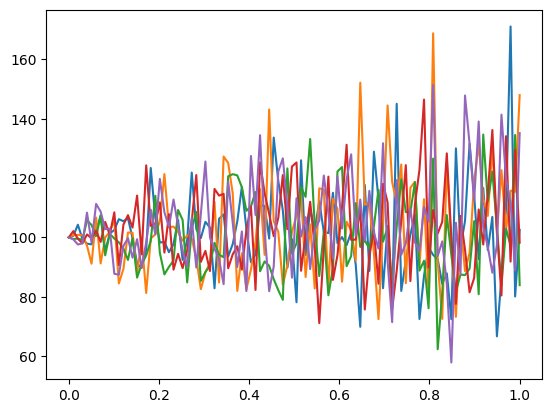

In [28]:
plot_trajectories(5, 100)

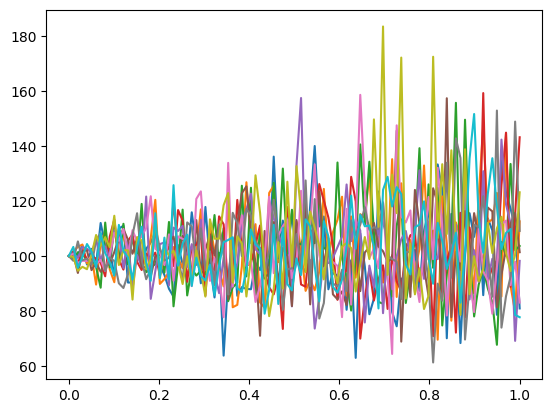

In [36]:
S_0 = 0
plot_trajectories(10, 100)